In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, concatenate

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2, 7"

### Dataset

In [3]:
dataset = pd.read_csv('../../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
# data.tail(10)

### Dataset Information

In [5]:
print(list(data.columns))

['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN']


### Pre-processing

In [6]:
# specify the number of lag hours
n_hours = 24*3
K = 24
n_features = data.shape[1]

#### Stage

In [7]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)

# stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
stages_supervised = series_to_supervised(stages, n_hours, K)
stages_supervised.reset_index(drop=True, inplace=True)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [8]:
# stages_supervised

#### Prior unknown covariates (6)

In [9]:
prior_unknown_cov = data[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown_cov.shape:", prior_unknown_cov.shape)

prior_unknown_cov_supervised = series_to_supervised(prior_unknown_cov, n_hours, K)
print("prior_unknown_cov_supervised.shape:", prior_unknown_cov_supervised.shape)

prior_unknown_cov.shape: (96432, 6)
prior_unknown_cov_supervised.shape: (96337, 576)


In [10]:
prior_unknown_cov_supervised.reset_index(drop=True, inplace=True)
prior_unknown_cov_supervised.columns = ['past_unknown_cov_' + i for i in list(prior_unknown_cov_supervised.columns)]

In [11]:
prior_unknown_cov_supervised

,past_unknown_cov_var1(t-72),past_unknown_cov_var2(t-72),past_unknown_cov_var3(t-72),past_unknown_cov_var4(t-72),past_unknown_cov_var5(t-72),past_unknown_cov_var6(t-72),past_unknown_cov_var1(t-71),past_unknown_cov_var2(t-71),past_unknown_cov_var3(t-71),past_unknown_cov_var4(t-71),...,past_unknown_cov_var3(t+22),past_unknown_cov_var4(t+22),past_unknown_cov_var5(t+22),past_unknown_cov_var6(t+22),past_unknown_cov_var1(t+23),past_unknown_cov_var2(t+23),past_unknown_cov_var3(t+23),past_unknown_cov_var4(t+23),past_unknown_cov_var5(t+23),past_unknown_cov_var6(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
2,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
3,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
4,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
96333,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.0,1.94,504.67,2.39,...,0.0,2.89,287.12,2.54,0.0,1.94,0.0,2.90,253.27,2.58


#### Prior known covariates (9)

In [12]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
prior_known_cov = data[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known_cov.shape:", prior_known_cov.shape)

prior_known_cov_supervised = series_to_supervised(prior_known_cov, n_hours, K)
print("prior_known_cov_supervised.shape:", prior_known_cov_supervised.shape)

prior_known_cov.shape: (96432, 9)
prior_known_cov_supervised.shape: (96337, 864)


In [13]:
prior_known_cov_supervised.reset_index(drop=True, inplace=True)
prior_known_cov_supervised.columns = ['past_known_cov_' + i for i in list(prior_known_cov_supervised.columns)]

In [14]:
prior_known_cov_supervised

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var1(t-71),...,past_known_cov_var9(t+22),past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23)
0,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.42,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.008750,-0.01,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


In [15]:
prior_known_future_cov = prior_known_cov_supervised.iloc[:, n_hours*prior_known_cov.shape[1]:]
prior_known_future_cov

,past_known_cov_var1(t),past_known_cov_var2(t),past_known_cov_var3(t),past_known_cov_var4(t),past_known_cov_var5(t),past_known_cov_var6(t),past_known_cov_var7(t),past_known_cov_var8(t),past_known_cov_var9(t),past_known_cov_var1(t+1),...,past_known_cov_var9(t+22),past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23)
0,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,1.47,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.83,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.31,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.18,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.18,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.55,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,2.08,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.92,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.92,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.55,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,1.55,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.08,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


In [16]:
prior_known_future_cov.shape

(96337, 216)

### N_out, N_in, K

In [17]:
# specify the number of lag hours
n_features = stages.shape[1] + prior_unknown_cov.shape[1] + prior_known_cov.shape[1]

In [18]:
n_features

19

### Concatenation

In [19]:
past_prior_unknown_cov_supervised = prior_unknown_cov_supervised.iloc[:, :n_hours*prior_unknown_cov.shape[1]]
past_prior_known_cov_supervised = prior_known_cov_supervised.iloc[:, :n_hours*prior_known_cov.shape[1]]

In [20]:
# prior_known_cov_supervised

In [21]:
columns = []
for i in range(n_hours):
    columns = columns + past_prior_unknown_cov_supervised.columns[i*prior_unknown_cov.shape[1]:(i+1)*prior_unknown_cov.shape[1]].tolist()
    columns = columns + past_prior_known_cov_supervised.columns[i*prior_known_cov.shape[1]:(i+1)*prior_known_cov.shape[1]].tolist()
# columns

In [22]:
past_unknown_known_cov = concat([past_prior_unknown_cov_supervised, past_prior_known_cov_supervised],
                                axis=1)

In [23]:
past_unknown_known_cov

,past_unknown_cov_var1(t-72),past_unknown_cov_var2(t-72),past_unknown_cov_var3(t-72),past_unknown_cov_var4(t-72),past_unknown_cov_var5(t-72),past_unknown_cov_var6(t-72),past_unknown_cov_var1(t-71),past_unknown_cov_var2(t-71),past_unknown_cov_var3(t-71),past_unknown_cov_var4(t-71),...,past_known_cov_var9(t-2),past_known_cov_var1(t-1),past_known_cov_var2(t-1),past_known_cov_var3(t-1),past_known_cov_var4(t-1),past_known_cov_var5(t-1),past_known_cov_var6(t-1),past_known_cov_var7(t-1),past_known_cov_var8(t-1),past_known_cov_var9(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.0,1.94,504.67,2.39,...,0.0,1.92,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


In [24]:
# non_stages_supervised.reset_index(drop=True, inplace=True)
# stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([past_unknown_known_cov, stages_supervised.iloc[:, :]], axis=1)

In [25]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 1464)


In [26]:
# all_data

### Train & Test set

In [27]:
all_data = all_data.values
future_covariates = prior_known_future_cov.values

In [28]:
n_train_hours = int(len(data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 77145


In [29]:
train_future_cov = prior_known_future_cov.iloc[:n_train_hours, :]
test_future_cov = prior_known_future_cov.iloc[n_train_hours:, :] 

In [30]:
test_future_cov.shape

(19192, 216)

### Normalization

In [31]:
n_hours

72

In [32]:
n_features

19

In [33]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77145, 1368) (77145, 96) (19192, 1368) (19192, 96)


In [34]:
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))

train_future_cov = scaler1.fit_transform(train_future_cov)
test_future_cov = scaler1.fit_transform(test_future_cov)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (77145, 216) (19192, 216)


In [35]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77145, 72, 19) (77145, 96) (19192, 72, 19) (19192, 96)


In [36]:
train_future_cov = train_future_cov.reshape(train_future_cov.shape[0], K, -1)
test_future_cov = test_future_cov.reshape(test_future_cov.shape[0], K, -1)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (77145, 24, 9) (19192, 24, 9)


In [37]:
# train_y = train_y.reshape((train_y.shape[0], K, -1))
# test_y = test_y.reshape((test_y.shape[0], K, -1))
# print(train_y.shape, test_y.shape)

### Model

In [39]:
# Encoding the past
past_inputs = tf.keras.Input(shape=(n_hours, n_features), name='past_inputs')
encoder = tf.keras.layers.Conv1D(filters=256, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_inputs)
encoder = tf.keras.layers.Conv1D(filters=128, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.Conv1D(filters=64, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.Conv1D(filters=train_future_cov.shape[2], 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)


# Combine past + future
future_inputs = tf.keras.Input(shape=(K, prior_known_cov.shape[1]), name='future_inputs')

past_future_input = concatenate([encoder, future_inputs], axis=1)


# decoder
decoder = tf.keras.layers.Conv1D(filters=128, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_future_input)
decoder = tf.keras.layers.Conv1D(filters=64, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.Conv1D(filters=32, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.Conv1D(filters=16, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)

fc = layers.Flatten()(decoder)

# final output
fc = tf.keras.layers.Dense(256, activation='relu')(fc)
fc = tf.keras.layers.Dense(128, activation='relu')(fc)
fc = tf.keras.layers.Dense(64, activation='relu')(fc)
output = tf.keras.layers.Dense(train_y.shape[1])(fc)

model = tf.keras.models.Model(inputs=[past_inputs, future_inputs], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 72, 19)]     0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 72, 256)      9984        past_inputs[0][0]                
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 72, 128)      65664       conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 72, 64)       16448       conv1d_9[0][0]                   
____________________________________________________________________________________________

Epoch 1/6000


2023-02-05 20:46:27.731672: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-05 20:46:27.930659: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-05 20:46:28.900149: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-02-05 20:46:29.179410: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.06186, saving model to saved_model/cnn_encoder_decoder_24h_ws.h5
151/151 - 77s - loss: 0.0725 - mae: 0.1208 - val_loss: 0.0274 - val_mae: 0.0619
Epoch 2/6000

Epoch 00002: val_mae improved from 0.06186 to 0.03639, saving model to saved_model/cnn_encoder_decoder_24h_ws.h5
151/151 - 3s - loss: 0.0140 - mae: 0.0241 - val_loss: 0.0101 - val_mae: 0.0364
Epoch 3/6000

Epoch 00003: val_mae improved from 0.03639 to 0.03575, saving model to saved_model/cnn_encoder_decoder_24h_ws.h5
151/151 - 3s - loss: 0.0066 - mae: 0.0177 - val_loss: 0.0064 - val_mae: 0.0357
Epoch 4/6000

Epoch 00004: val_mae improved from 0.03575 to 0.03403, saving model to saved_model/cnn_encoder_decoder_24h_ws.h5
151/151 - 3s - loss: 0.0041 - mae: 0.0162 - val_loss: 0.0047 - val_mae: 0.0340
Epoch 5/6000

Epoch 00005: val_mae improved from 0.03403 to 0.03266, saving model to saved_model/cnn_encoder_decoder_24h_ws.h5
151/151 - 3s - loss: 0.0029 - mae: 0.0149 - val_loss: 0.0037 - va

Epoch 52/6000

Epoch 00052: val_mae improved from 0.02789 to 0.02785, saving model to saved_model/cnn_encoder_decoder_24h_ws.h5
151/151 - 3s - loss: 4.9202e-04 - mae: 0.0108 - val_loss: 0.0014 - val_mae: 0.0279
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.02785
151/151 - 3s - loss: 4.9039e-04 - mae: 0.0108 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.02785
151/151 - 3s - loss: 4.8681e-04 - mae: 0.0107 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.02785
151/151 - 3s - loss: 4.8522e-04 - mae: 0.0107 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.02785
151/151 - 3s - loss: 4.8490e-04 - mae: 0.0107 - val_loss: 0.0015 - val_mae: 0.0292
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.02785
151/151 - 3s - loss: 4.8489e-04 - mae: 0.0108 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 58/6000

Epoch 00058: val_mae did not impro

Epoch 106/6000

Epoch 00106: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.3329e-04 - mae: 0.0103 - val_loss: 0.0014 - val_mae: 0.0282
Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.3319e-04 - mae: 0.0103 - val_loss: 0.0014 - val_mae: 0.0283
Epoch 108/6000

Epoch 00108: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.3352e-04 - mae: 0.0103 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 109/6000

Epoch 00109: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.3251e-04 - mae: 0.0103 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 110/6000

Epoch 00110: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.2988e-04 - mae: 0.0102 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 111/6000

Epoch 00111: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.2992e-04 - mae: 0.0102 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.3057e-04 - mae: 0

Epoch 161/6000

Epoch 00161: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.1032e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 162/6000

Epoch 00162: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.0946e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 163/6000

Epoch 00163: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.1085e-04 - mae: 0.0101 - val_loss: 0.0013 - val_mae: 0.0279
Epoch 164/6000

Epoch 00164: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.0916e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 165/6000

Epoch 00165: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.2079e-04 - mae: 0.0104 - val_loss: 0.0019 - val_mae: 0.0334
Epoch 166/6000

Epoch 00166: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.2255e-04 - mae: 0.0105 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 167/6000

Epoch 00167: val_mae did not improve from 0.02742
151/151 - 3s - loss: 4.0952e-04 - mae: 0

Epoch 216/6000

Epoch 00216: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0519e-04 - mae: 0.0101 - val_loss: 0.0013 - val_mae: 0.0281
Epoch 217/6000

Epoch 00217: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0502e-04 - mae: 0.0101 - val_loss: 0.0015 - val_mae: 0.0292
Epoch 218/6000

Epoch 00218: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0582e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 219/6000

Epoch 00219: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0591e-04 - mae: 0.0101 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 220/6000

Epoch 00220: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0416e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 221/6000

Epoch 00221: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0487e-04 - mae: 0.0101 - val_loss: 0.0013 - val_mae: 0.0283
Epoch 222/6000

Epoch 00222: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0342e-04 - mae: 0

Epoch 271/6000

Epoch 00271: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9810e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0289
Epoch 272/6000

Epoch 00272: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0036e-04 - mae: 0.0101 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 273/6000

Epoch 00273: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9753e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0287
Epoch 274/6000

Epoch 00274: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9735e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 275/6000

Epoch 00275: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9723e-04 - mae: 0.0100 - val_loss: 0.0013 - val_mae: 0.0279
Epoch 276/6000

Epoch 00276: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9797e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 277/6000

Epoch 00277: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9672e-04 - mae: 0

Epoch 326/6000

Epoch 00326: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9471e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0289
Epoch 327/6000

Epoch 00327: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9531e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 328/6000

Epoch 00328: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9364e-04 - mae: 0.0100 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 329/6000

Epoch 00329: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9454e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 330/6000

Epoch 00330: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.1777e-04 - mae: 0.0107 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 331/6000

Epoch 00331: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9680e-04 - mae: 0.0102 - val_loss: 0.0014 - val_mae: 0.0294
Epoch 332/6000

Epoch 00332: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9362e-04 - mae: 0

Epoch 381/6000

Epoch 00381: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9356e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 382/6000

Epoch 00382: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9254e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 383/6000

Epoch 00383: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9743e-04 - mae: 0.0102 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 384/6000

Epoch 00384: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0384e-04 - mae: 0.0105 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 385/6000

Epoch 00385: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9286e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0282
Epoch 386/6000

Epoch 00386: val_mae did not improve from 0.02704
151/151 - 4s - loss: 3.9171e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 387/6000

Epoch 00387: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9213e-04 - mae: 0

Epoch 436/6000

Epoch 00436: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9140e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 437/6000

Epoch 00437: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9010e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 438/6000

Epoch 00438: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9071e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 439/6000

Epoch 00439: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9066e-04 - mae: 0.0100 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 440/6000

Epoch 00440: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9119e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 441/6000

Epoch 00441: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9035e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 442/6000

Epoch 00442: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9079e-04 - mae: 0

Epoch 491/6000

Epoch 00491: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9699e-04 - mae: 0.0102 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 492/6000

Epoch 00492: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9346e-04 - mae: 0.0101 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 493/6000

Epoch 00493: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9277e-04 - mae: 0.0101 - val_loss: 0.0015 - val_mae: 0.0296
Epoch 494/6000

Epoch 00494: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9218e-04 - mae: 0.0101 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 495/6000

Epoch 00495: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9210e-04 - mae: 0.0101 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 496/6000

Epoch 00496: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9140e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 497/6000

Epoch 00497: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9129e-04 - mae: 0

Epoch 546/6000

Epoch 00546: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8821e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 547/6000

Epoch 00547: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8922e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 548/6000

Epoch 00548: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8784e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0288
Epoch 549/6000

Epoch 00549: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8826e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 550/6000

Epoch 00550: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8835e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 551/6000

Epoch 00551: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8833e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 552/6000

Epoch 00552: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8818e-04 - mae: 0

Epoch 601/6000

Epoch 00601: val_mae did not improve from 0.02704
151/151 - 4s - loss: 3.8534e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 602/6000

Epoch 00602: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0598e-04 - mae: 0.0106 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 603/6000

Epoch 00603: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8671e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 604/6000

Epoch 00604: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8578e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 605/6000

Epoch 00605: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8600e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 606/6000

Epoch 00606: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8494e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0302
Epoch 607/6000

Epoch 00607: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8531e-04 - mae: 0

Epoch 656/6000

Epoch 00656: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8434e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 657/6000

Epoch 00657: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8963e-04 - mae: 0.0102 - val_loss: 0.0016 - val_mae: 0.0306
Epoch 658/6000

Epoch 00658: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8362e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 659/6000

Epoch 00659: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8407e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 660/6000

Epoch 00660: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8393e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0296
Epoch 661/6000

Epoch 00661: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8397e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 662/6000

Epoch 00662: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9312e-04 - mae: 0

Epoch 711/6000

Epoch 00711: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8176e-04 - mae: 0.0099 - val_loss: 0.0016 - val_mae: 0.0304
Epoch 712/6000

Epoch 00712: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8189e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 713/6000

Epoch 00713: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8341e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0287
Epoch 714/6000

Epoch 00714: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8239e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 715/6000

Epoch 00715: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8285e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 716/6000

Epoch 00716: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.0857e-04 - mae: 0.0106 - val_loss: 0.0025 - val_mae: 0.0393
Epoch 717/6000

Epoch 00717: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.1402e-04 - mae: 0

Epoch 766/6000

Epoch 00766: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7970e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 767/6000

Epoch 00767: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8132e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 768/6000

Epoch 00768: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8044e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 769/6000

Epoch 00769: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7982e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 770/6000

Epoch 00770: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8001e-04 - mae: 0.0099 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 771/6000

Epoch 00771: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.5913e-04 - mae: 0.0113 - val_loss: 0.0035 - val_mae: 0.0470
Epoch 772/6000

Epoch 00772: val_mae did not improve from 0.02704
151/151 - 3s - loss: 4.3871e-04 - mae: 0

Epoch 821/6000

Epoch 00821: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7839e-04 - mae: 0.0098 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 822/6000

Epoch 00822: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7860e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 823/6000

Epoch 00823: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7791e-04 - mae: 0.0098 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 824/6000

Epoch 00824: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7806e-04 - mae: 0.0098 - val_loss: 0.0016 - val_mae: 0.0308
Epoch 825/6000

Epoch 00825: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7979e-04 - mae: 0.0099 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 826/6000

Epoch 00826: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8383e-04 - mae: 0.0100 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 827/6000

Epoch 00827: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.8512e-04 - mae: 0

Epoch 876/6000

Epoch 00876: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7666e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 877/6000

Epoch 00877: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7730e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0296
Epoch 878/6000

Epoch 00878: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7606e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 879/6000

Epoch 00879: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7700e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 880/6000

Epoch 00880: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7642e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 881/6000

Epoch 00881: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7727e-04 - mae: 0.0098 - val_loss: 0.0016 - val_mae: 0.0304
Epoch 882/6000

Epoch 00882: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7604e-04 - mae: 0

Epoch 931/6000

Epoch 00931: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7458e-04 - mae: 0.0097 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 932/6000

Epoch 00932: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7442e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 933/6000

Epoch 00933: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7431e-04 - mae: 0.0097 - val_loss: 0.0017 - val_mae: 0.0313
Epoch 934/6000

Epoch 00934: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7519e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 935/6000

Epoch 00935: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7444e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 936/6000

Epoch 00936: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7454e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 937/6000

Epoch 00937: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7518e-04 - mae: 0

Epoch 986/6000

Epoch 00986: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7367e-04 - mae: 0.0097 - val_loss: 0.0016 - val_mae: 0.0302
Epoch 987/6000

Epoch 00987: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7342e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 988/6000

Epoch 00988: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7440e-04 - mae: 0.0098 - val_loss: 0.0016 - val_mae: 0.0308
Epoch 989/6000

Epoch 00989: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7356e-04 - mae: 0.0097 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 990/6000

Epoch 00990: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7303e-04 - mae: 0.0097 - val_loss: 0.0017 - val_mae: 0.0308
Epoch 991/6000

Epoch 00991: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7315e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 992/6000

Epoch 00992: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7322e-04 - mae: 0

Epoch 1041/6000

Epoch 01041: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7252e-04 - mae: 0.0097 - val_loss: 0.0016 - val_mae: 0.0305
Epoch 1042/6000

Epoch 01042: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7239e-04 - mae: 0.0097 - val_loss: 0.0016 - val_mae: 0.0304
Epoch 1043/6000

Epoch 01043: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7172e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 1044/6000

Epoch 01044: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7246e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 1045/6000

Epoch 01045: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7174e-04 - mae: 0.0097 - val_loss: 0.0016 - val_mae: 0.0308
Epoch 1046/6000

Epoch 01046: val_mae did not improve from 0.02704
151/151 - 3s - loss: 5.5908e-04 - mae: 0.0137 - val_loss: 0.0014 - val_mae: 0.0287
Epoch 1047/6000

Epoch 01047: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7739e-04 -

Epoch 1096/6000

Epoch 01096: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7130e-04 - mae: 0.0097 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 1097/6000

Epoch 01097: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7162e-04 - mae: 0.0097 - val_loss: 0.0017 - val_mae: 0.0313
Epoch 1098/6000

Epoch 01098: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7217e-04 - mae: 0.0097 - val_loss: 0.0016 - val_mae: 0.0301
Epoch 1099/6000

Epoch 01099: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7124e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 1100/6000

Epoch 01100: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7120e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 1101/6000

Epoch 01101: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7112e-04 - mae: 0.0097 - val_loss: 0.0017 - val_mae: 0.0312
Epoch 1102/6000

Epoch 01102: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7155e-04 -

Epoch 1151/6000

Epoch 01151: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.9364e-04 - mae: 0.0104 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 1152/6000

Epoch 01152: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7323e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 1153/6000

Epoch 01153: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7172e-04 - mae: 0.0097 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 1154/6000

Epoch 01154: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7161e-04 - mae: 0.0097 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 1155/6000

Epoch 01155: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7138e-04 - mae: 0.0097 - val_loss: 0.0015 - val_mae: 0.0292
Epoch 1156/6000

Epoch 01156: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7131e-04 - mae: 0.0097 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 1157/6000

Epoch 01157: val_mae did not improve from 0.02704
151/151 - 3s - loss: 3.7189e-04 -

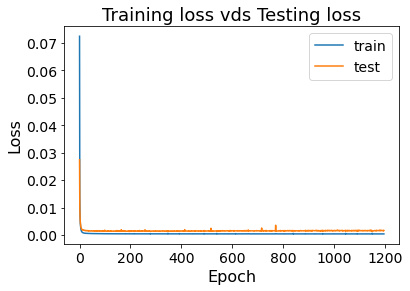

In [40]:
lr = 0.00001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


model.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
                optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/cnn_encoder_decoder_24h_ws.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model.fit(x=[train_X, train_future_cov], y=train_y, 
                    epochs=EPOCHS,
                    verbose=2,
                    validation_data=([test_X, test_future_cov], test_y),
                    batch_size = 512,
                    callbacks=[es, mc]
                   )

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vds Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [41]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/cnn_encoder_decoder_24h_ws.h5')

In [42]:
y_hat = model.predict([test_X, test_future_cov])

In [43]:
print(y_hat.shape)
print(test_y.shape)

(19192, 96)
(19192, 96)


In [44]:
inv_yhat = scaler.inverse_transform(y_hat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19192, 96) (19192, 96)


### Performance

In [45]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.143
RMSE = 0.178
